# EfficientNetV2 with CIFAR-10 Benchmark

### SOTA Model and Training Procedure

Author : Wong Zhao Wu

# Abstract
Improving the performance of a vision model is product of the following three different sections [(Cited from Revisiting ResNets)](https://arxiv.org/pdf/2103.07579.pdf).
1. Model Architecture
2. Training Procedure
3. Scaling Method *(Not Enough Computation Power to Explore)*

In CA1, the goal is to implement state of the art model architecture, training procudure and dataset augmentation without compromising the generalisation capability and performance of the model. 

To achieve the goal, I have make use of the [EfficientNetV2 (Tan, M., & Le, Q. V., 2021)](https://arxiv.org/abs/2104.00298) model family that has achieve that has achieved 99% accuracy and comparable to other ViT models from [paperswithcode CIFAR-10 Benchmark Leaderboard](https://paperswithcode.com/sota/image-classification-on-cifar-10). EfficientNetV2 is a Convolutional Network Family that is production of Neural Architecture Search (NAS) with implementations of latest modelling techniques like Fused-MBConv Net from [MobileNetV2 Paper (Sandler. etgi al, 2018)](https://arxiv.org/abs/1801.04381v4) with [Squeeze-and-Excitation (Hu et al.,
2018)](https://arxiv.org/abs/1709.01507).

As for the training procedure, I have gain inspiration from the EfficientNetV2 paper to introduce **Progressive Learning** to scale the input image resolution *([Progressive Resizing](https://www.bookstack.cn/read/th-fastai-book/spilt.3.798d5ac22392691a.md))* and regularization *([RandAugment](https://arxiv.org/abs/1909.13719), [Dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/), [Stochastic Depth](https://arxiv.org/abs/1603.09382), L2 Regularization)* progressively to speed up the training without causing accuracy drop.

Although I did not managed to achieve the same performance as the leaderboard with proper training-validation-test split convention, I managed to achieve accuracy of 92.55% on 10,000 test set and gain practical experience in training and building model in Pytorch.

# Notebook Initialization
If you are running this notebook on Google Colab, you need to clone the working repository.

## Clone Working Repo

> If you are running this notebook on Local Instance, you can skip the following steps to clone the repo.

The next two cell will complete the job for you.

In [2]:
# Clone Repo for Dataset
!git clone https://github.com/kiritowu/Deep-Learning.git
%cd EfficientNetV2-with-Image-Classification-Benchmarks

Cloning into 'DELE-Temp-CA'...
remote: Enumerating objects: 1482, done.
remote: Counting objects: 100% (1482/1482), done.
remote: Compressing objects: 100% (1404/1404), done.
remote: Total 1482 (delta 134), reused 1384 (delta 64), pack-reused 0
Receiving objects: 100% (1482/1482), 362.16 MiB | 32.14 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Checking out files: 100% (1269/1269), done.
Filtering content: 100% (8/8), 918.05 MiB | 87.08 MiB/s, done.
/content/DELE-Temp-CA
fetch: Fetching reference refs/heads/main


## Import Modules & Global Variables

Before importing any of the modules, we need to make sure the packages are up to date.

Since the packages on Google Colab is outdated, we need to manually Upgrade the packages to get the cells running.

Other than the raw Pytorch packages family *(e.g. torch, torchvision)*, I have installed two extra packages namely,
1. [timm](https://github.com/rwightman/pytorch-image-models)

    Deep-learning library created by Ross Wightman and is a collection of SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts with ability to reproduce ImageNet training results.

    > I have used the library to access Pytorch implementation of EfficientNetV2 which is only released officially on Tensorflow.

In [3]:
# Upgrade and Install packages
!pip install --upgrade timm torch torchvision

     |████████████████████████████████| 1.7 MB 8.7 MB/s 
     |████████████████████████████████| 376 kB 75.1 MB/s 
     |████████████████████████████████| 97 kB 8.9 MB/s 
     |████████████████████████████████| 140 kB 69.5 MB/s 
     |████████████████████████████████| 180 kB 79.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=c06b84f7c09e7a9dab34f324ca6a04b025798b5c36e187cc0d2676c4e3dee5de
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=30cebc1164c4f4719f3d7009d616ca931b41063d0717d0f1c015fb79b465d61b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [2]:
# ----------------------------Import Modules------------------------------ #
import os
import sys
import time
import timm
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, SubsetRandomSampler

# ----------------------------Env Variables-------------------------------- #
# Set small batch size to prevent overloading the RAM with high resolution pictures (Progressive Learning)
BATCH_SIZE = 32
# Number of CPU threads for number of worker
CPU_COUNT = os.cpu_count() 
BASE_FOLDER = os.getcwd()

## Import Utils from Torchvision Github Page

In `references/detection/` from [Torchvision Github](https://github.com/pytorch/vision), we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/utils.py`

Let's copy those files (and their dependencies) in here so that they are available in the notebook.

> The following cells are commented since files needed is downloaded.

In [ ]:
# # Lines below are commented since it is cloned in github repo
# %%shell

# # Download TorchVision repo to use some files from references/detection
# %cd ..
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.0

# cp references/detection/utils.py ../
# %cd ..

In [3]:
# Import utils.py for training and logging utilities
sys.path.append('../..')
import utils

## Checking GPU
To load the model, you need to first enable GPU runtime on Google Colab through "Runtime >> Change runtime type >> Hardware accelerator >> GPU".

Since I am using Colab-Pro subscription service, I am able to gain access to Tesla P-100. However, for a normal Colab user, you are normally assigned with Tesla K-80.

If you are running into trouble of not enough memory to run model, try to reduce the batch size.

In [3]:
# Check if Cuda GPU is available and Pytorch version
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Pytorch is currently using {device}")
# Check pytorch version 
assert torch.__version__ > '1.10.0', "Pytorch version is outdated, Please upgrade Pytorch to v1.10.0 or above"

Pytorch is currently using cuda


## Fix Global Random Seeds
Since I am running the experiments on different machines across multiple runs, I will set a fixed global random-state better evaluate the performance of the model in a more consistent manner. *(i.e. Data Splitting and Weights initializing will remain the same for every runs)*

In [4]:
# Set random seed for reproducibility
torch.manual_seed(7)
np.random.seed(7)

# Dataset Preparation

## Data Augmentation
For data augmentation, I utilises [RandAugment](https://arxiv.org/abs/1909.13719) which contains of sets of basic data augmentation techniques/policies. *(e.g. Identity, ShearX, ShearY, TranslateX, TranslateY, Rotate, Brightness, Color, Contrast, Sharpness, Posterize, Solarize, AutoContrast and Equalize)* 

The reason of choosing RandAugment is the ability to tune the `magnitude` of augmentation policies in line with the notion of progressive training (i.e. start with smaller magnitude and increase it step-by-step)

Other than data augmentation, I have also performed `Resize` using torchvision package to progressively scale up the resolution of input image.

The following diagram shows the hyperparameters used on different epoch

| Epoch | Image Resolution | RandAugment | 
| :--- | :--- | :--- | 
| 1-20 | 128 | 10 |
| 21-40 | 128 | 15 |
| 41-60 | 200 | 20 |

In [5]:
# Mean and Std of FashionMNIST dataset are obtained online
_CIFAR_MEAN = (0.485, 0.456, 0.406)
_CIFAR_STD  = (0.229, 0.224, 0.225)

rand_aug_train = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.autoaugment.RandAugment(magnitude = 20),
    transforms.ToTensor(), 
    transforms.Normalize(_CIFAR_MEAN, _CIFAR_STD),
])

rand_aug_test = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.ToTensor(), 
    transforms.Normalize(_CIFAR_MEAN, _CIFAR_STD),
])

## Downloading Dataset
After creating the transform pipeline, I will now download the CIFAR10 dataset using built-in torchvision Classes.

In [6]:
#  Allow download with unverified SSL to escape from SSL error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context 

# Downloading CIFAR10 Dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform = rand_aug_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform = rand_aug_test)

Files already downloaded and verified
Files already downloaded and verified


## Data Loader with Train-Dev-Test split

Finally, I have performed Train-Dev-Test split on the training and testing dataset before wraping into `DataLoader` class to generate an iterable data generator.

In [7]:
train_length = train_data.__len__() # Length training dataset
train_indices = np.arange(train_length) # Create arange 
np.random.shuffle(train_indices) # Randomly Suffle training indices

train_loader = DataLoader(
                        train_data, 
                        batch_size=BATCH_SIZE, 
                        sampler = SubsetRandomSampler(train_indices[:int(train_length*0.8)]) # 80% of data in train set
                    )

val_loader = DataLoader(
                        train_data, 
                        batch_size=BATCH_SIZE, 
                        sampler = SubsetRandomSampler(train_indices[int(train_length*0.8):]) #20% of data in validation set
                    )

test_loader = DataLoader(
                        test_data, 
                        batch_size=BATCH_SIZE,
                    )

# Disable Data Augmentation on Validation Set
val_loader.dataset.transform = rand_aug_test
val_loader.dataset.transform

Compose(
    Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)

# Basic EDA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


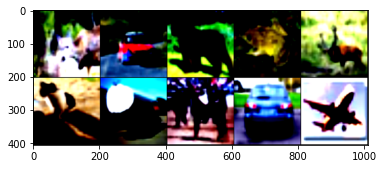

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


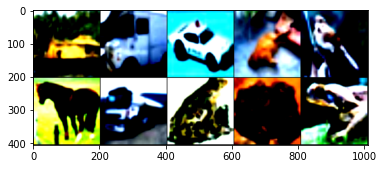

In [ ]:
training_batch = next(iter(train_loader))
validation_batch = next(iter(val_loader))

train_img = torchvision.utils.make_grid(training_batch[0][:10], nrow=5)
plt.imshow(train_img.permute(1,2,0))
plt.show()

validation_img = torchvision.utils.make_grid(validation_batch[0][:10], nrow=5)
plt.imshow(validation_img.permute(1,2,0))
plt.show()

# Building the Model

To build the EfficientNetV2 model, instead of implementing every components from scratch *(i.e. assembling furniture from IKEA)*, I make used of [timm](https://github.com/rwightman/pytorch-image-models) Package that contains pre-built Pytorch implementation *(i.e. buy furniture built by expert and modify from there)*.

To be fair, I did not used any of the pre-trained weights but to start the traning from scratch to better experiment on Progressive Training.

The following function is able to obtain the model with the following modifications:
1. Implement Progressive Learning with Increasing Dropout and Stochastic Depth Rate
2. Replace the Fully-Connected Layer to only 10 neuron (Since there are only 10 classes in CIFAR-10)

The default model choosen is EfficientNetV2-M since that is the biggest model that a single P-100 and RTX3090 can support. *(Will explore on parallelism next time)*

In [8]:
def get_custom_efficientnetv2(model_scale = 'm', training_phase = 's'):
    assert model_scale in ['s', 'm', 'l', 'xl'], "Please specify model_scale with alphabert 's', 'm', 'l', 'xl' only."
    assert training_phase in ['s', 'm', 'l'], "Please specify Progressive training phase with alphabert 's', 'm', 'l' only."

    # Model Size
    if training_phase == 's':
        model_kwargs = dict(drop_rate=0.2, drop_path_rate=0)
    elif training_phase == 'm':
        model_kwargs = dict(drop_rate=0.3, drop_path_rate=0.1)
    elif training_phase == 'l':
        model_kwargs = dict(drop_rate=0.4, drop_path_rate=0.2)

    # Import Model Architecture
    model = timm.create_model(f"efficientnetv2_{model_scale}", **model_kwargs)
    model.classifier = nn.Sequential(
        nn.Linear(in_features = 1280, out_features = 10) # Final layer with 10 classes
    )
    return model

In [ ]:
model = get_custom_efficientnetv2(training_phase='s') # Import model
model.to(device) # Move model to the right device

EfficientNet(
  (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (2): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act

# Training Model

The following cells contains code to train the model. Do run all Training & Validation Utilities and Criterions to carry out training and inference smoothly.

## Training and Validation Utilities

The following codes are direct reference from [HabanaAI/Model-Reference](https://github.com/HabanaAI/Model-References/blob/master/PyTorch/computer_vision/ImageClassification/ResNet/train.py) training script with comments & modifications to better display the training and evaluation process.

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        #pdb.set_trace()
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)

        pred = pred.t()
        pred_cpu = torch.tensor(pred, device='cpu')
        target_cpu = torch.tensor(target, device='cpu')

        correct = pred_cpu.eq(target_cpu[None])

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().sum(dtype=torch.float32)
            res.append(correct_k * (100.0 / batch_size))
        return res

In [ ]:
def train_one_epoch(model:nn.Module, 
                    criterion:nn.CrossEntropyLoss, 
                    optimizer, 
                    data_loader:torch.utils.data.DataLoader, 
                    device:str, 
                    epoch:int, 
                    print_freq:int, 
                    apex=False, 
                    warmup=True) -> None:
    
    # Set training mode
    model.train() 
    # Logging Utils
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.8f}'))
    metric_logger.add_meter('img/s', utils.SmoothedValue(window_size=10, fmt='{value:.0f}'))

    header = 'Epoch: [{}]'.format(epoch)
    step_count = 0
    last_print_time= time.time()

    # Early Warm-Up
    warmup_lr_scheduler = None
    if epoch == 0 and warmup:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        warmup_lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    # Traing Loop
    for image, target in metric_logger.log_every(data_loader, print_freq, header):
        image, target = image.to(device), target.to(device) # Move image and target to GPU if possible

        dl_ex_start_time=time.time()

        output = model(image) # Forward Prop
        loss = criterion(output, target) # Calculate Loss
        optimizer.zero_grad() # Clear previous gradients

        loss.backward() # Calculate gradient to the loss

        optimizer.step() # Gradient descent step

        if warmup_lr_scheduler is not None:
            warmup_lr_scheduler.step() # Update Learning Rate if Warmup

        if step_count % print_freq == 0: # Print training log
            output_cpu = output.detach().to('cpu')
            acc1, acc5 = accuracy(output_cpu, target, topk=(1, 5))
            batch_size = image.shape[0]
            metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
            metric_logger.meters['acc1'].update(acc1.item(), n=batch_size*print_freq)
            metric_logger.meters['acc5'].update(acc5.item(), n=batch_size*print_freq)
            current_time = time.time()
            last_print_time = dl_ex_start_time #if args.dl_time_exclude else last_print_time
            metric_logger.meters['img/s'].update(batch_size*print_freq / (current_time - last_print_time))
            last_print_time = time.time()

In [ ]:
@torch.no_grad() # Disable Autograd for Evaluation Function
def evaluate(model:nn.Module, 
             criterion:nn.CrossEntropyLoss, 
             data_loader:torch.utils.data.DataLoader, 
             device:str, 
             epoch:int, 
             print_freq:int=40, 
             ) -> None:

    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    total = 0
    correct = 0
    step_count = 0
    last_print_time= time.time()

    for image, target in metric_logger.log_every(data_loader, 100, header):
        image, target = image.to(device), target.to(device) # Move image and target to GPU if possible

        dl_ex_start_time=time.time()
        
        output = model(image) # Forward Prop
        loss = criterion(output, target) # Calculate Loss
        
        # Accumulate correct prediction
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Print training log
        if step_count % print_freq == 0: 
            output_cpu = output.detach().to('cpu')
            acc1, acc5 = accuracy(output_cpu, target, topk=(1, 5))
            batch_size = image.shape[0]
            metric_logger.meters['acc1'].update(acc1.item(), n=batch_size*print_freq)
            metric_logger.meters['acc5'].update(acc5.item(), n=batch_size*print_freq)
            current_time = time.time()
            last_print_time = dl_ex_start_time 
            metric_logger.meters['img/s'].update(batch_size*print_freq / (current_time - last_print_time + 1e-5)) # Added small number to avoid floor division error
            last_print_time = time.time()

    # Display final accuracy
    print('Accuracy of the network on the 10000 test images: {:.4f}'.format(100 * correct / total))

## Training Configurations

`configs` contain the initial training hyperparameters that we will use.

In [ ]:
configs = {
    "LR" : 1e-3,
    "WD" : 3e-3,
    "CURREPOCHS":0,
    "MAXEPOCHS":60
}

## Optimizer and Criterion

For optimizer, I decided to go with Adam since it works well with default hyperparameters and Adam remains a strong contender despite the emergence of new techniques. [(Cited from Descending Through Crowded Valley)](https://arxiv.org/abs/2007.01547)

Moreover, an exponentially decreasing learning rate scheduler is used to decrease the learning rate progressively as the training proceeds to better descend the loss valley. 

In [ ]:
# Construct Adan Optimizer
model_params = [p for p in model.parameters() if p.requires_grad] # Getting Model Parameters that Requires Training
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # Using Categorical Cross-Entropy as Objective Function(Loss Function)
optimizer = optim.Adam(model_params, 
                        lr = configs['LR'], 
                        weight_decay = configs['WD'])

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma = 0.9
)

> Please do not run this cell if you are not consider to retrain the model!
## Training Loop

In [ ]:
for _ in range(configs['CURREPOCHS'], configs['MAXEPOCHS']):
    # get current epochs
    epoch = configs['CURREPOCHS']

    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, print_freq=40)

    # update the learning rate
    lr_scheduler.step() if lr_scheduler else None

    # increase current epoch number
    configs['CURREPOCHS'] += 1

    # # evaluate on the validation dataset
    evaluate(model, criterion, val_loader, device, epoch)

<ipython-input-14-707df12a0533>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_cpu = torch.tensor(pred, device='cpu')
<ipython-input-14-707df12a0533>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_cpu = torch.tensor(target, device='cpu')


Epoch: [55]  [   0/1250]  eta: 0:11:50  lr: 0.00003000  img/s: 6089  loss: 0.3208 (0.3208)  acc1: 87.5000 (87.5000)  acc5: 100.0000 (100.0000)  time: 0.5684  data: 0.3101  max mem: 8086
Epoch: [55]  [  40/1250]  eta: 0:06:07  lr: 0.00003000  img/s: 6059  loss: 0.2138 (0.2413)  acc1: 93.7500 (91.6921)  acc5: 100.0000 (99.4665)  time: 0.2969  data: 0.0813  max mem: 8087
Epoch: [55]  [  80/1250]  eta: 0:06:08  lr: 0.00003000  img/s: 6022  loss: 0.2592 (0.2460)  acc1: 90.6250 (91.1265)  acc5: 100.0000 (99.6142)  time: 0.3545  data: 0.0828  max mem: 8087
Epoch: [55]  [ 120/1250]  eta: 0:06:00  lr: 0.00003000  img/s: 6087  loss: 0.2108 (0.2416)  acc1: 93.7500 (91.2190)  acc5: 100.0000 (99.7159)  time: 0.2975  data: 0.0818  max mem: 8087
Epoch: [55]  [ 160/1250]  eta: 0:05:41  lr: 0.00003000  img/s: 6081  loss: 0.2253 (0.2474)  acc1: 90.6250 (91.3432)  acc5: 100.0000 (99.6700)  time: 0.2975  data: 0.0816  max mem: 8087
Epoch: [55]  [ 200/1250]  eta: 0:05:38  lr: 0.00003000  img/s: 5964  loss:

## Saving Model

Finally, the model is saved in `models/effnetv2_m_3.pth` for inference purposes.

In [ ]:
save_path = os.path.join(BASE_FOLDER,"models", "effnetv2_m_3.pth")
torch.save(model.state_dict(), save_path)

# Test Validation

## Load Trained Model Weights

The following cell is able to load the pretrained weights from the file directory for inference purposes.

In [9]:
model = get_custom_efficientnetv2(training_phase = 'm')
model.load_state_dict(torch.load(os.path.join(BASE_FOLDER,"models", "effnetv2_m_3.pth")))
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (2): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act

In [ ]:
evaluate(model, criterion, test_loader, device, epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Test:  [  0/313]  eta: 0:01:41  acc1: 96.8750 (96.8750)  acc5: 100.0000 (100.0000)  img/s: 9375.0879 (9375.0878)  time: 0.3247  data: 0.1781  max mem: 646
Test:  [100/313]  eta: 0:00:27  acc1: 93.7500 (92.5743)  acc5: 100.0000 (99.6287)  img/s: 10790.2051 (10771.9869)  time: 0.1282  data: 0.0048  max mem: 646
Test:  [200/313]  eta: 0:00:14  acc1: 93.7500 (92.4285)  acc5: 100.0000 (99.7201)  img/s: 10788.7305 (10780.7055)  time: 0.1294  data: 0.0058  max mem: 646
Test:  [300/313]  eta: 0:00:01  acc1: 93.7500 (92.5457)  acc5: 100.0000 (99.7508)  img/s: 10785.5225 (10783.8675)  time: 0.1284  data: 0.0050  max mem: 646
Test:  [312/313]  eta: 0:00:00  acc1: 93.7500 (92.5500)  acc5: 100.0000 (99.7500)  img/s: 10791.8105 (10778.5542)  time: 0.1257  data: 0.0050  max mem: 646
Test: Total time: 0:00:40 (0.1294 s / it)
Accuracy of the network on the 10000 test images: 92.55


In [10]:
current_batch = 0
test_images = iter(test_loader)
class_names = [
            "airplane",
            "automobile",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

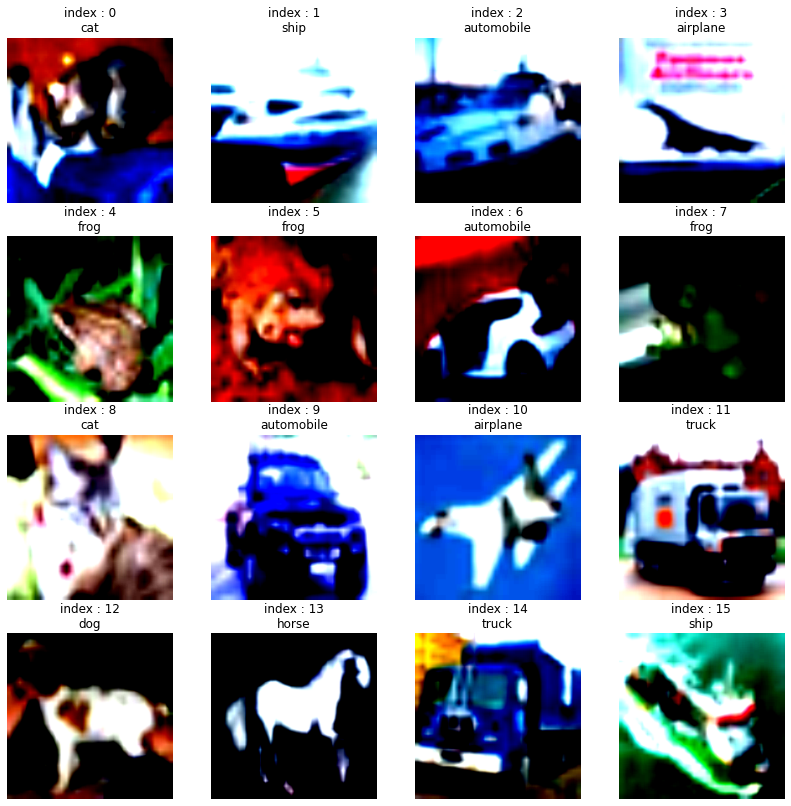

In [11]:
plt.figure(figsize=(14, 14))
images, labels= next(test_images)
img, labels = images.to(device), labels.to(device)
model.eval()
predictions = model(img)
y_pred = torch.argmax(predictions, dim=1).to("cpu")
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images[i].permute(1,2,0).numpy())
  current_index = current_batch*BATCH_SIZE+i
  plt.title(f"index : {current_index}\n{class_names[int(y_pred[current_index:current_index+1])]}")
  plt.axis("off")
current_batch += 1